In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import zipfile
from google.colab import files
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import requests
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
DATASET_URL = "https://github.com/Arfazrll/CA-Modul03-HandsOn/releases/download/ConvolutionalNeuralNetwork/rockpaperscissors.zip"

def download_dataset(url, output_file='rockpaperscissors.zip'):
    if not os.path.exists(output_file):
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        with open(output_file, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download completed")
    else:
        print("Dataset already exists")

def extract_dataset(zip_file='rockpaperscissors.zip', extract_to='data/'):
    if not os.path.exists(extract_to):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction completed")
    else:
        print("Dataset already extracted")

download_dataset(DATASET_URL)
extract_dataset()

Download completed
Extracting dataset...
Extraction completed


In [3]:
BASE_DIR = 'data/rockpaperscissors/rps-cv-images'
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.4

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
Training samples: 1314
Validation samples: 874


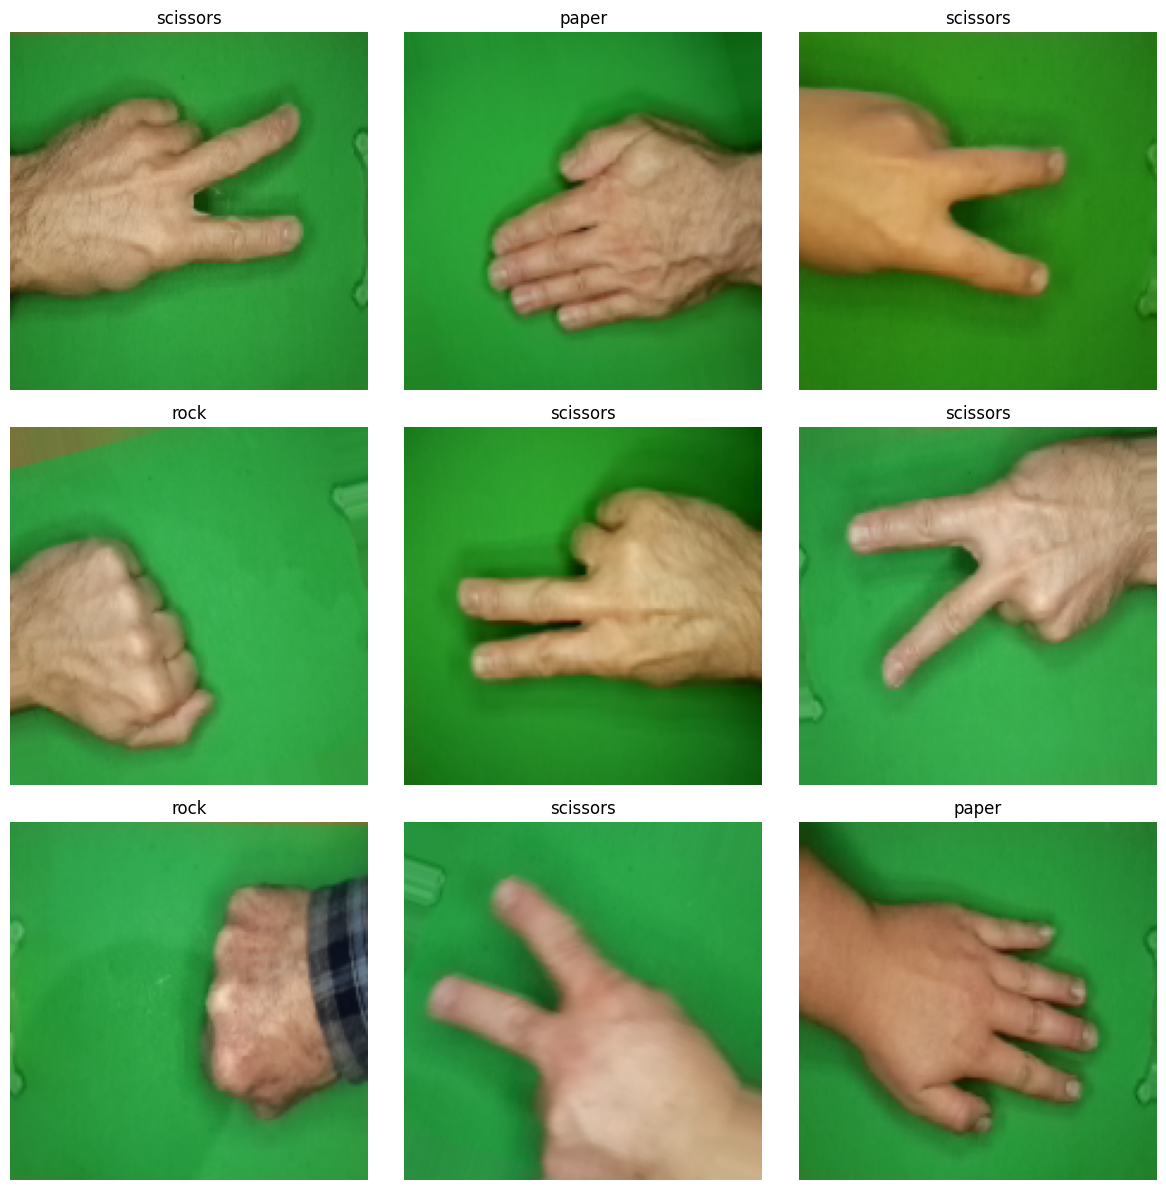

In [5]:
def plot_samples(generator, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        label_idx = np.argmax(labels[i])
        axes[i].set_title(f'{class_names[label_idx]}', fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150)
    plt.show()

plot_samples(train_generator)

In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.4249 - loss: 1.0687 - val_accuracy: 0.5126 - val_loss: 0.8239
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.7454 - loss: 0.6069 - val_accuracy: 0.8890 - val_loss: 0.3200
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.8937 - loss: 0.2827 - val_accuracy: 0.9336 - val_loss: 0.1953
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.9318 - loss: 0.2196 - val_accuracy: 0.9600 - val_loss: 0.1550
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.9242 - loss: 0.2099 - val_accuracy: 0.9428 - val_loss: 0.2051
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9108 - loss: 0.2510 - val_accuracy: 0.9611 - val_loss: 0.1230
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.9474 - loss: 0.1391 - val_accuracy: 0.9645 - val_loss: 0.1081
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9592 - loss: 0.1017 - val_accu

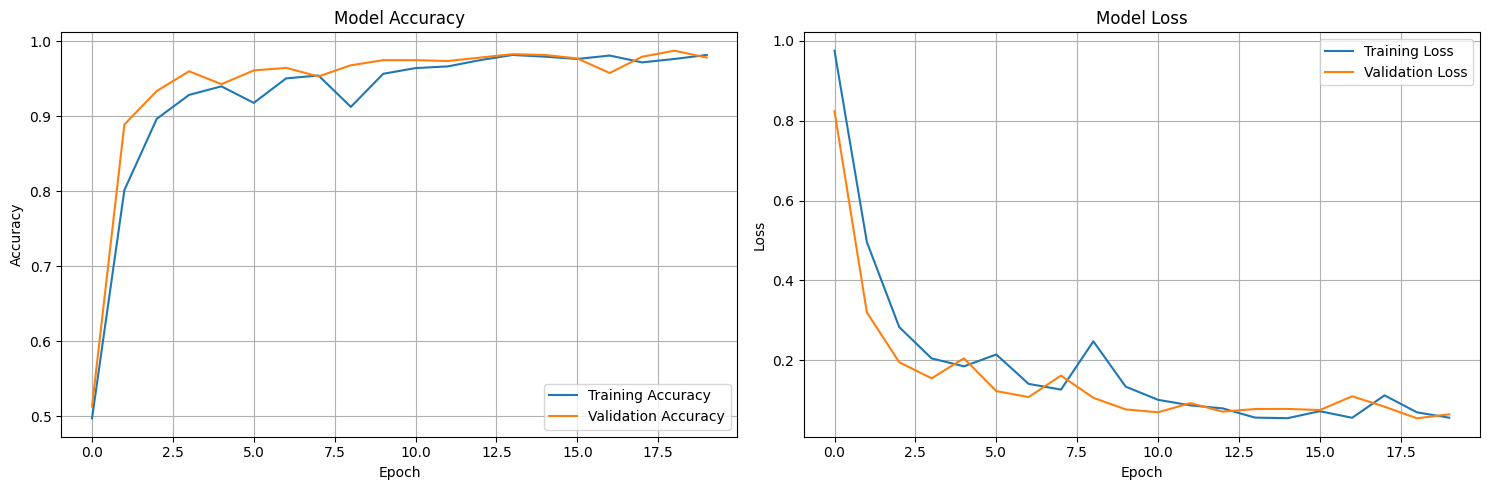

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f'\nValidation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)')

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9741 - loss: 0.0712

Validation Loss: 0.0649
Validation Accuracy: 0.9783 (97.83%)


In [22]:
val_cm_generator = validation_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

pred_probs = model.predict(val_cm_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_cm_generator.classes
class_labels = list(val_cm_generator.class_indices.keys())

Found 874 images belonging to 3 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


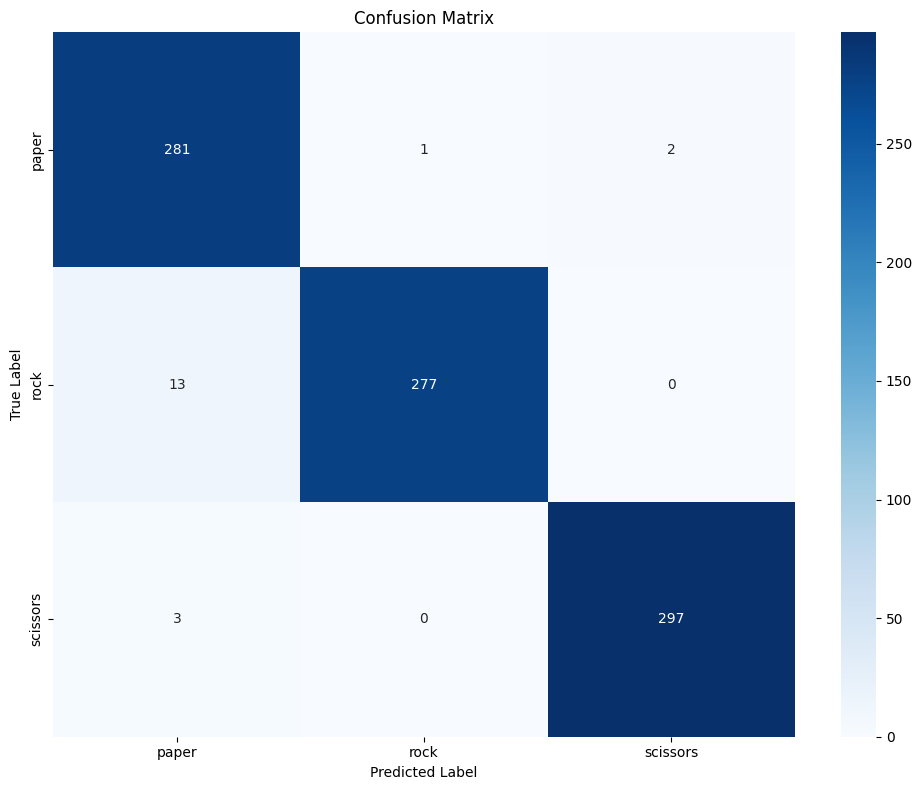

In [23]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

Saving 0ePX1wuCc3et7leL.png to 0ePX1wuCc3et7leL.png
Nama file: 0ePX1wuCc3et7leL.png


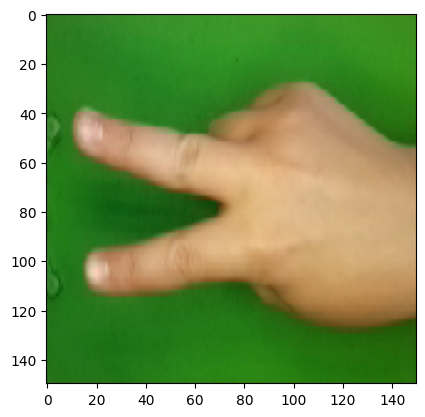

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Gambar tersebut adalah: scissors


In [24]:
uploaded = files.upload()

for fn in uploaded.keys():
    print('Nama file:', fn)
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    imgplot = plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    class_indices = train_generator.class_indices
    class_indices = dict((v,k) for k,v in class_indices.items())
    predicted_class = class_indices[np.argmax(classes)]
    print('Gambar tersebut adalah:', predicted_class)